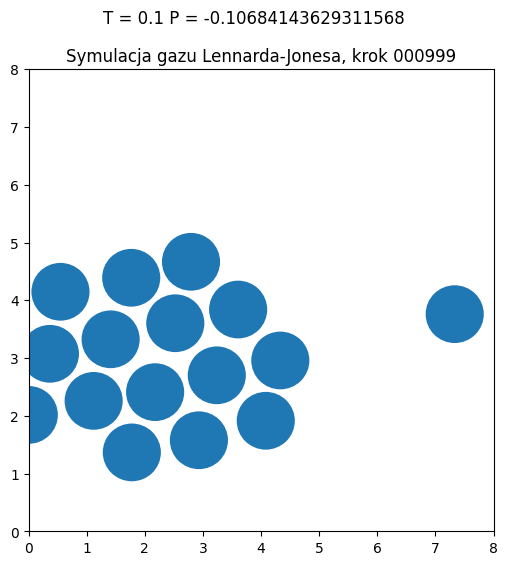

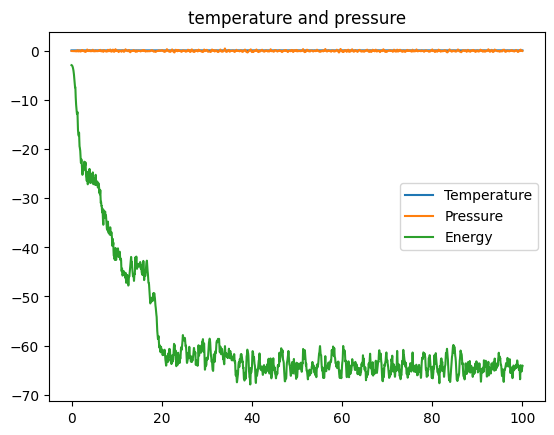

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import imageio.v2 as imageio
import os

os.makedirs('images', exist_ok=True)

N = 16
box_size = 8.0
eps = 1.0
sigma = 1.0
particle_radius = sigma / 2.0
dt = 0.0025
T_ext = 0.1
kB = 1.
m = 1.

steps = 100000

dt = 0.001

class particle:

    rs = np.array([])
    ts = np.array([0])
    v_halfs = np.array([])


    def __init__(self, particle_radius, r, v, id):
        self.particle_radius = particle_radius
        self.r = r
        self.v = v
        self.id = id
        self.rs = np.array([r])
        self.vs = np.array([v])



particles = []

for i in range(4):
    for j in range(4):

        v = np.array([np.random.uniform(-0.5, 0.5), np.random.uniform(-0.5, 0.5)])
        # make dependent on box size
        r = np.array([1 + 2*i, 1 + 2*j])
        p = particle(particle_radius, r, v, f'{i}{j}')
        particles.append(p)

def kinetic_energy(particle):
    return 0.5 * m * np.dot(particle.v, particle.v)

# add func to scale v to adjust to init temp
v = np.array([p.v for p in particles])
v_cm = sum(v) / N

for particle in particles:
    particle.v -= v_cm

Ek_mean = sum([kinetic_energy(p) for p in particles]) / N

fs = np.sqrt(kB * T_ext / Ek_mean)

for particle in particles:
    particle.v = fs * particle.v


Ek_mean = sum([kinetic_energy(p) for p in particles]) / N


def unit_vector(r):
    x, y = r
    magnitude = np.sqrt(x**2 + y**2)
    if magnitude == 0:
        raise ValueError("Zero vector has no direction — cannot compute unit vector.")
    return r / magnitude

def forceFrom(r):
    magnitude = np.linalg.norm(r)
    if magnitude == 0:
        return [0.,0.]
    return 24 * eps * unit_vector(r) * ( (2 * ( sigma / magnitude ) ** 13) -  (( sigma / magnitude ) ** 7) ) / magnitude

def force(i, rs, particles_rs):
    force = np.array([0., 0.])
    for ri in particles_rs:

    # trzeba przeskalować do tego kawdratu
        distance =  rs[i] - ri[i]
        distance = closest_picture(distance)
        force += forceFrom(distance)
    return force

def potential_energy(i, rs, particles_rs):
    energy = 0.
    for ri in particles_rs:

    # trzeba przeskalować do tego kawdratu
        distance =  closest_picture(rs[i] - ri[i])
        magnitude = np.linalg.norm(distance)
        if magnitude == 0:
            energy_i = 0
        else:
            energy_i = 4 * eps * ( (( sigma / magnitude ) ** 12) -  (( sigma / magnitude ) ** 6) ) * m
        energy += energy_i

    return energy


filenames = []
def closest_picture(r):
    if r[0] > box_size/2:
        r[0] -= box_size
    if r[0] < -box_size/2:
        r[0] += box_size
    if r[1] > box_size/2:
        r[1] -= box_size
    if r[1] < -box_size/2:
        r[1] += box_size
    return r

def move_back_to_box(r):
    if r[0] > box_size:
        r[0] -= box_size
    if r[0] < 0:
        r[0] += box_size
    if r[1] > box_size:
        r[1] -= box_size
    if r[1] < 0:
        r[1] += box_size
    return r

def trajectory(particles, steps=1000):

    Ks = np.array([]) # kinetic energy
    Kts = np.array([]) # kinetic energy w/thermostat
    Vts = np.array([])  # potential energy
    Ts = np.array([]) #
    Tts = np.array([])
    Ps = np.array([])
    Pts = np.array([])
    ts = np.array([])

    for i in range(steps):
        Ki = 0.
        Kti = 0.
        Vti = 0.

        for particle in particles:

            F = force(i, particle.rs, [p.rs for p in particles])

            vi_half = particle.v_halfs[-1] if len(particle.v_halfs) != 0 else particle.v - ( F * dt / (2 * m) )
            vi = vi_half + (F * dt / (2 * m))

            particle.ts = np.append(particle.ts, particle.ts[-1] + dt)
            Ki += 0.5 * m * np.dot(vi, vi)


        # deserves a func
        Ti = Ki / (N * kB)
        A = box_size ** 2
        viral = viralCorrection(i, [p.rs for p in particles])
        Pi = (N * kB * Ti / A ) + (viral / (2 * A))
        Ps = np.append(Ps, Pi)
        eta = np.sqrt(T_ext / Ti)


        for particle in particles:

            ri = move_back_to_box(particle.rs[-1])
            vi_half = particle.v_halfs[-1] if len(particle.v_halfs) != 0 else particle.v - ( F * dt / (2 * m) )
            F = force(i, particle.rs, [p.rs for p in particles])
            vii_half = (2*eta - 1) * vi_half + (eta * F * dt / m)

            rii = move_back_to_box(ri + vii_half * dt)

            particle.rs = np.append(particle.rs, [rii], axis=0)

            particle.v_halfs = np.vstack([particle.v_halfs, vii_half]) if len(particle.v_halfs) > 0 else np.array([vii_half])
            vi = 0.5 * (vi_half + vii_half)
            Kti += 0.5 * m * np.dot(vi, vi)
            Vti += potential_energy(i, particle.rs, [p.rs for p in particles])

        Kts = np.append(Kts, Kti)
        Tti = Kti / (N * kB)
        Tts = np.append(Tts, Tti)
        Vts = np.append(Vts, Vti)

        viral = viralCorrection(i, [p.rs for p in particles])
        Pti = (N * kB * Tti / A ) + (viral / (2 * A))
        Pts = np.append(Pts, Pti)

        t = i*dt
        ts = np.append(ts, t)


    return Kts, Vts, Tts, Pts, ts

def viralCorrection(i, particles_rs):
    correction = 0.

    for rj in particles_rs:
        for ri in particles_rs:

            distance = rj[i] - ri[i]

            distance = closest_picture(distance)
            F = forceFrom(distance)

            correction += np.dot(distance, F)
    correction *= 0.5
    return correction

K, V, T, P, t = trajectory(particles, steps)

E = K + V

def plot(steps):
    steps = int(steps/100)
    for i in range(steps):
        n = i * 100
        plt.clf() # wyczyść obrazek
        fig = plt.gcf() # zdefiniuj nowy
        for p in particles: # pętla po cząstkach
            a = plt.gca()
            cir = Circle((p.rs[n][0], p.rs[n][1]), radius = p.particle_radius) # kółko tam gdzie jest cząst
            a.add_patch(cir) # dodaj to kółko do rysunku
            plt.plot() # narysuj
        plt.xlim((0, box_size)) # obszar do narysowania
        plt.ylim((0, box_size))
        fig.set_size_inches((6, 6)) # rozmiar rysunku
        plt.title(f'Symulacja gazu Lennarda-Jonesa, krok {i:06d}')
        plt.suptitle(f'T = {T[i]} P = {P[i]}')
        name = f'images/img{i:06d}.png'
        filenames.append(name)
        plt.savefig(name)


plot(steps)

with imageio.get_writer('images/movie.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
plt.show()
plt.plot(t, T, label='Temperature')
plt.plot(t, P, label='Pressure')
plt.plot(t, E, label='Energy')
plt.legend()
plt.title(f"temperature and pressure")
plt.savefig("images/temperature and pressure.png")
plt.show()

